In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Importing Data

In [2]:
df = pd.read_csv('zillow_data.csv')
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
df.head()

,RegionID,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### Focusing on homes in Arizona

In [3]:
df = df[df['State']=='AZ']

In [4]:
df = df[(df['Metro'] == 'Phoenix')]

df = df[(df['zipcode'] == 85253)|(df['zipcode'] == 85262)|
(df['zipcode'] == 85377)| (df['zipcode'] == 85255)|(df['zipcode'] == 85266)|
                             (df['zipcode'] == 85259)|(df['zipcode'] == 85258)|
                             (df['zipcode'] == 85018)|(df['zipcode'] == 85263)|
                             (df['zipcode'] == 85054)]

Number of Unique Zipcodes in Arizona: 230

In [5]:
df['zipcode'].value_counts().sum()

10

# Reshaping Data

In [6]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['zipcode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
melted = melt_data(df)
melted = melted.set_index('time')
melted.shape

(2650, 8)

In [8]:
melted = melted['2009-04-01':'2018-04-01']

### Group by zipcode and Resampling to Monthly

In [9]:
resampled = melted.groupby('zipcode').resample('MS').mean().drop('zipcode',axis=1)
resampled = resampled[['value']]
resampled

value
zipcode time                
85018   2009-04-01  397600.0
        2009-05-01  392500.0
        2009-06-01  386800.0
        2009-07-01  381300.0
        2009-08-01  376200.0
...                      ...
85377   2017-12-01  865500.0
        2018-01-01  864700.0
        2018-02-01  863200.0
        2018-03-01  859600.0
        2018-04-01  854900.0

[1090 rows x 1 columns]

### Adding ZHVI forecasted monthly growth column

In [10]:
# shift by one period (month)
resampled_shift_1 = resampled[['value']].shift(1)
resampled_shift_1.bfill(inplace=True)

# reset the indexes to perform calculation of growth
resampled = resampled.reset_index()
resampled_shift_1 = resampled_shift_1.reset_index()

# Growth Calculation
resampled['growth'] = (resampled['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])

# set the index back to zipcode and time multi-index
resampled.set_index(['zipcode','time'],inplace=True)

In [11]:
resampled.loc[85018]

,value,growth
time,,
2009-04-01,397600.0,0.000000
2009-05-01,392500.0,-0.012827
2009-06-01,386800.0,-0.014522
2009-07-01,381300.0,-0.014219
2009-08-01,376200.0,-0.013375
...,...,...
2017-12-01,621700.0,0.011223
2018-01-01,629600.0,0.012707
2018-02-01,636000.0,0.010165


In [12]:
(392500-397600)/397600

-0.012826961770623743

# EDA

### Stationarity check functions

In [13]:
def plot_zip(zipcode,column):
    series = resampled.loc[zipcode,column]
    fig, ax = plt.subplots(figsize=(18,5))
    series.plot(ax=ax)
    ax.set_title("Zipcode: "+ str(zipcode));

In [14]:
def stationarity_check(TS):
    dftest = adfuller(TS)
    
    
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [15]:
def difference_check(zipcode,target,k):
    ts = resampled.loc[zipcode,target]
    
    print(f'The stationarity check for zipcode:{zipcode}, before differencing')
    print()
    print(stationarity_check(ts))
    print()
    
    #Original Plot
    fig, ax = plt.subplots()
    ax.plot(ts)
    ax.set_title(f"Original Zipcode Plot for {zipcode}");
    
    #diff and dropna
    ts_diff = ts.diff(k)
    ts_diff.dropna(inplace=True)
    
    fig, ax = plt.subplots()
    ax.plot(ts_diff)
    ax.set_title(f"{k} order differencing Plot for Zipcode: {zipcode}");

    print(f'The stationarity check for zipcode:{zipcode}, after differencing:')
    print()
    print(stationarity_check(ts_diff))

In [16]:
def p_values(TS):
    dftest = adfuller(TS)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput['p-value']

In [17]:
def p_val_after_diff(zipcode,target,k):
    ts = resampled.loc[zipcode,target]
    ts_diff = ts.diff(k)
    ts_diff.dropna(inplace=True)
    return (zipcode, p_values(ts_diff))

### Looking at Value stationarity

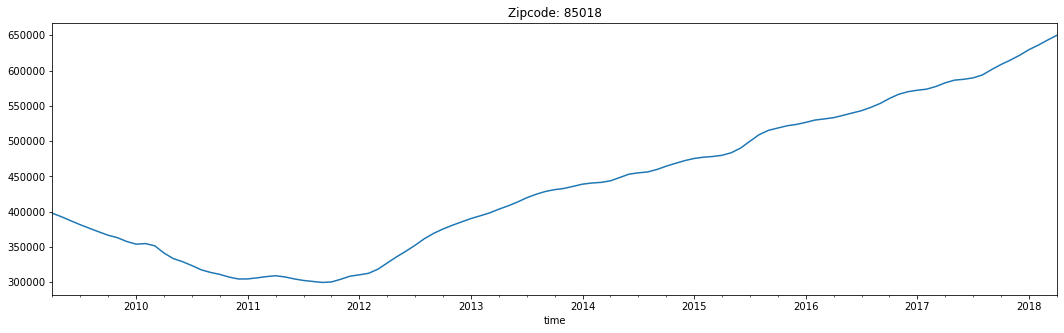

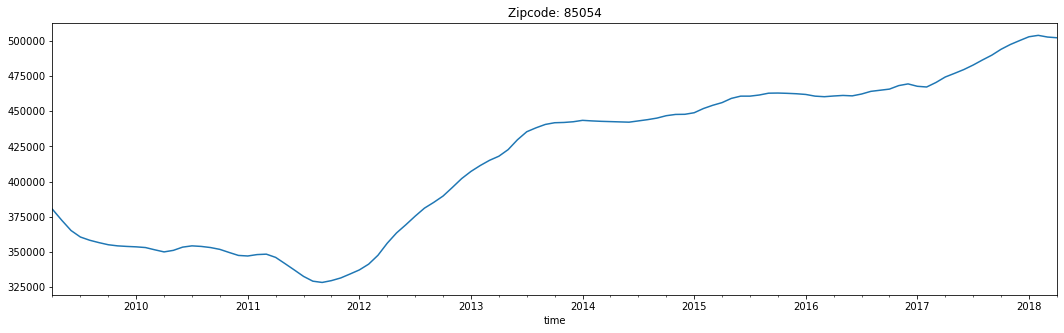

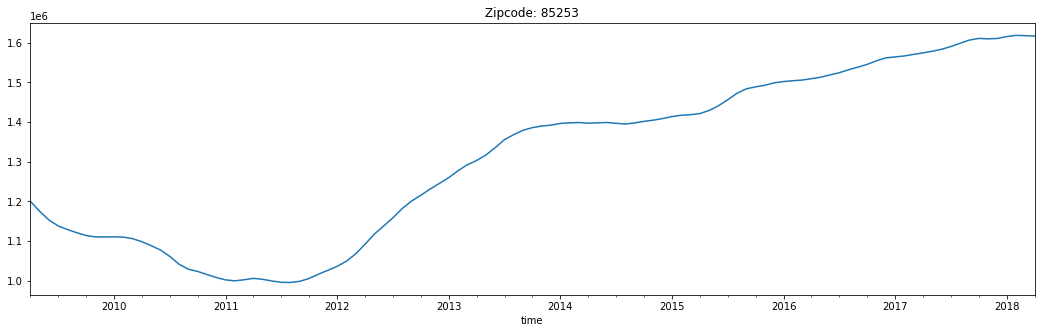

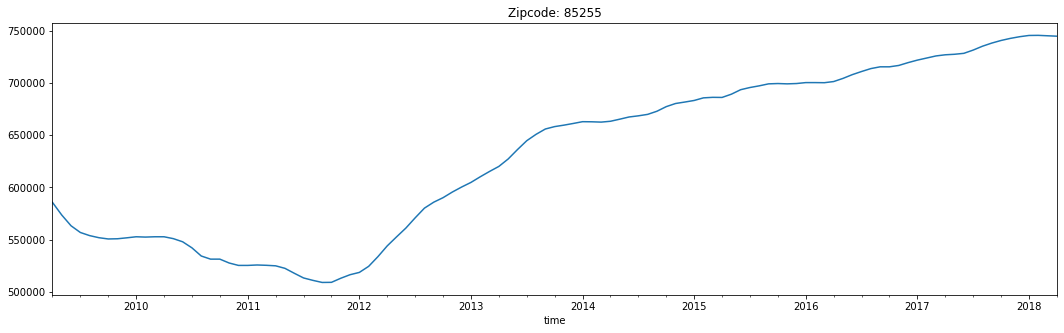

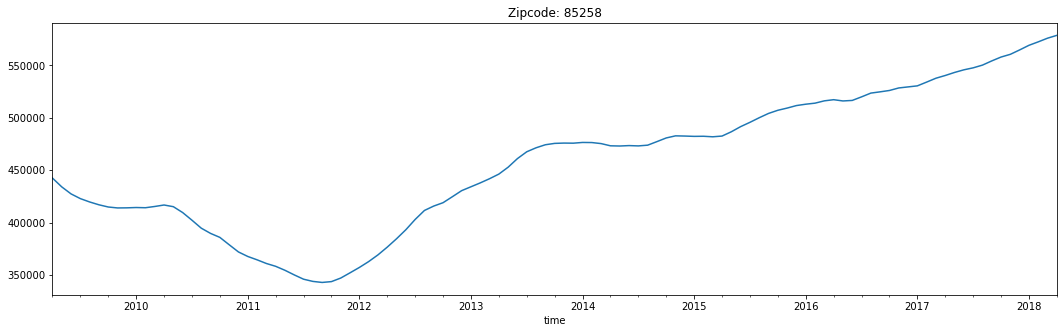

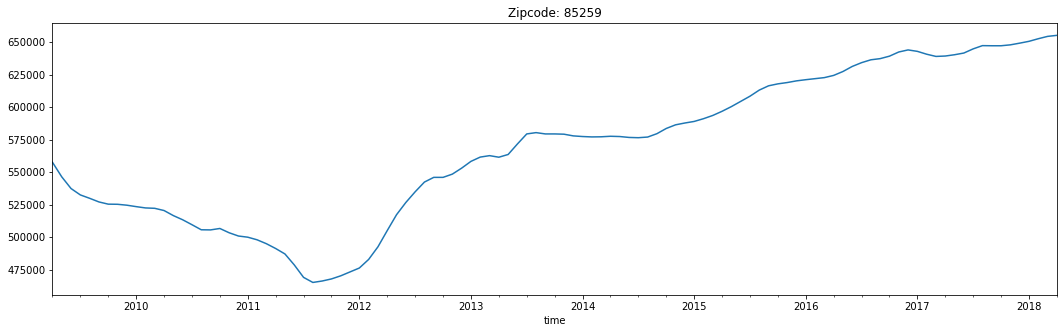

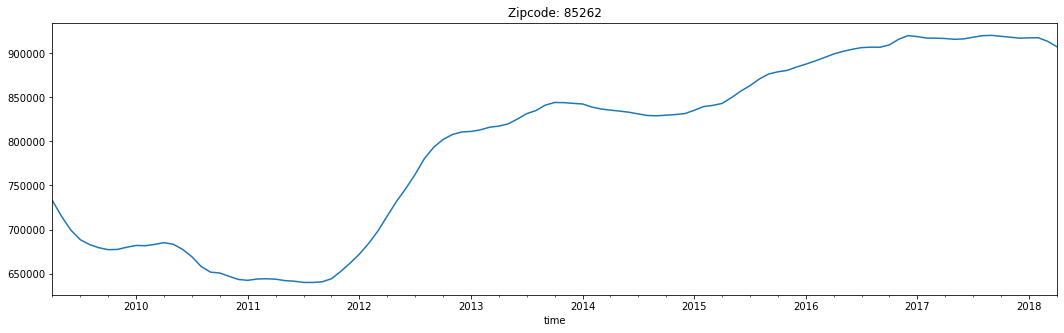

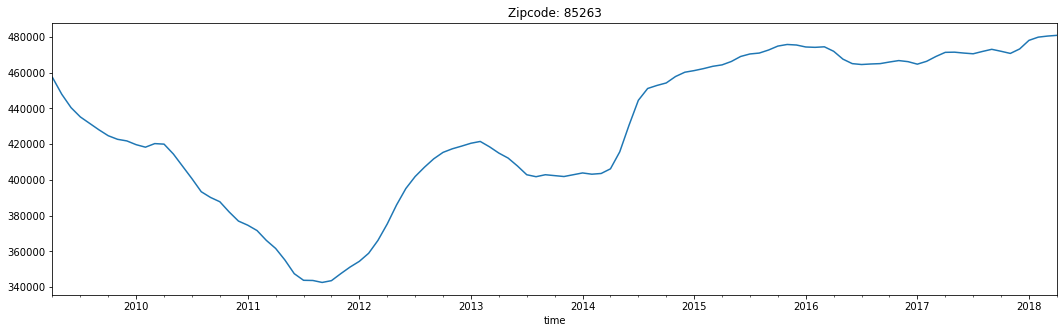

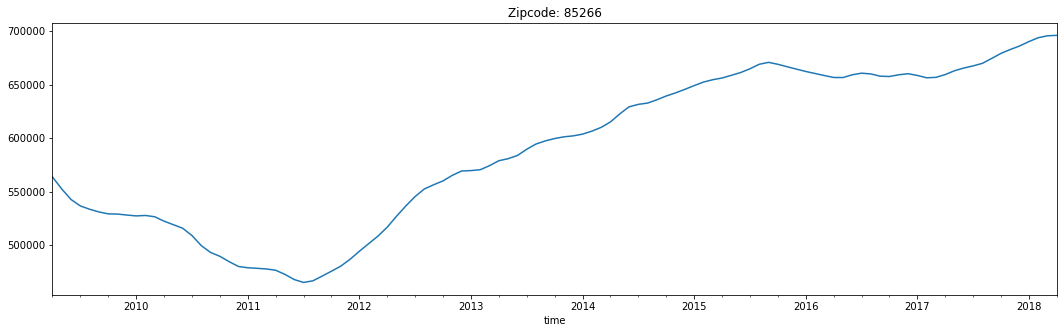

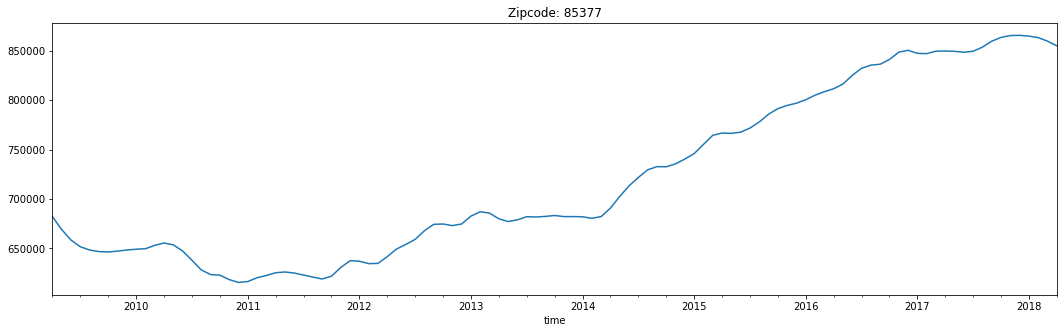

In [18]:
copy = resampled.reset_index()
for z in copy.zipcode.unique():
    plot_zip(z,'value')

They all show an increasing trend after 2008

In [19]:
for z in copy.zipcode.unique():
    print("zipcode: "+ str(z))
    print(stationarity_check(resampled.loc[z,'value']))
    print()

zipcode: 85018
Results of Dickey-Fuller Test: 

Test Statistic                   0.512578
p-value                          0.985250
#Lags Used                       4.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64
None

zipcode: 85054
Results of Dickey-Fuller Test: 

Test Statistic                 -0.960562
p-value                         0.767376
#Lags Used                     12.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
None

zipcode: 85253
Results of Dickey-Fuller Test: 

Test Statistic                  -1.355085
p-value                          0.603610
#Lags Used                       8.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)    

All 10 zipcodes are NOT Stationary

### Looking at Growth Stationary

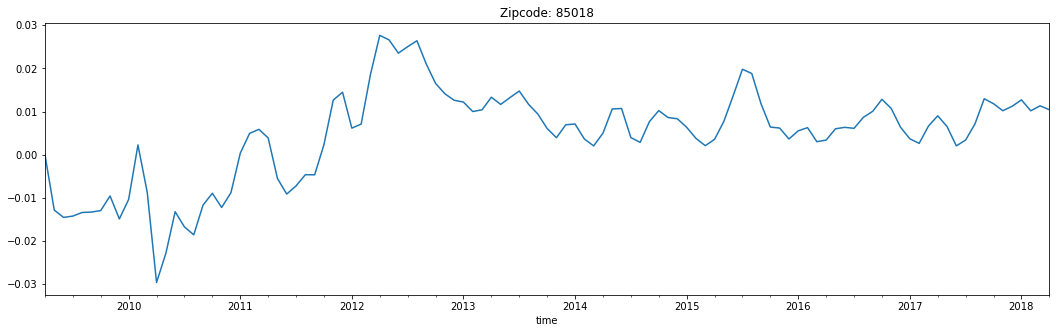

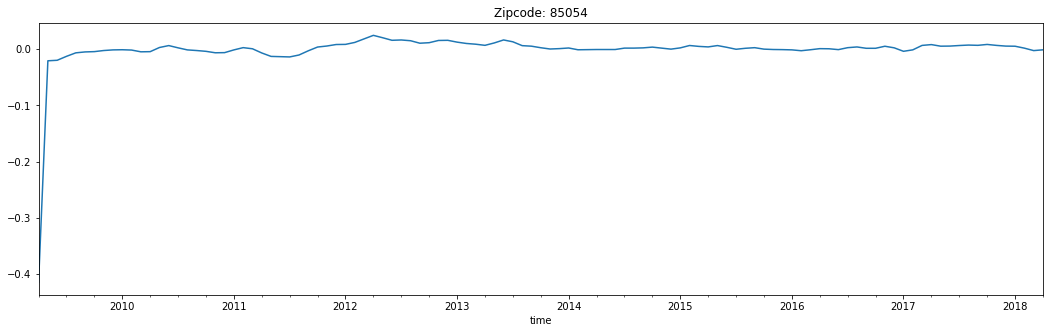

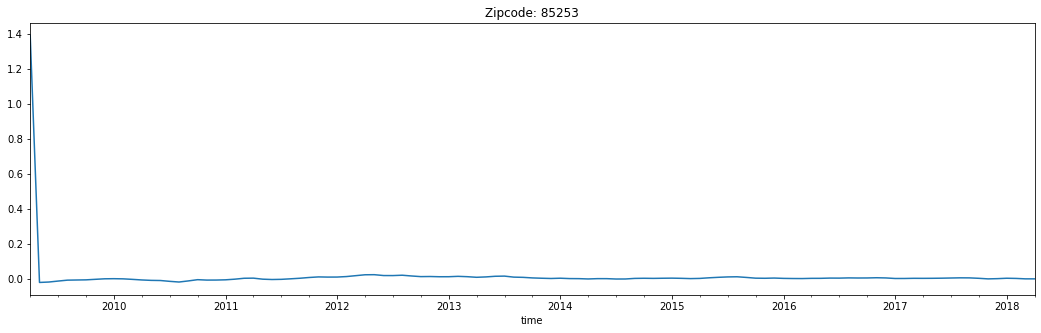

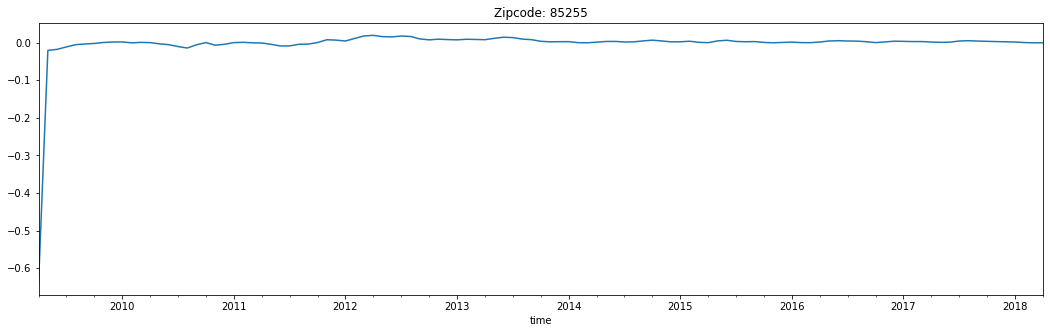

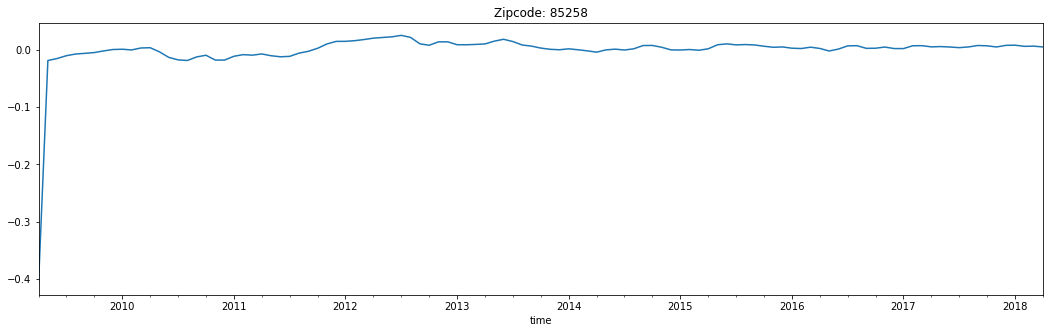

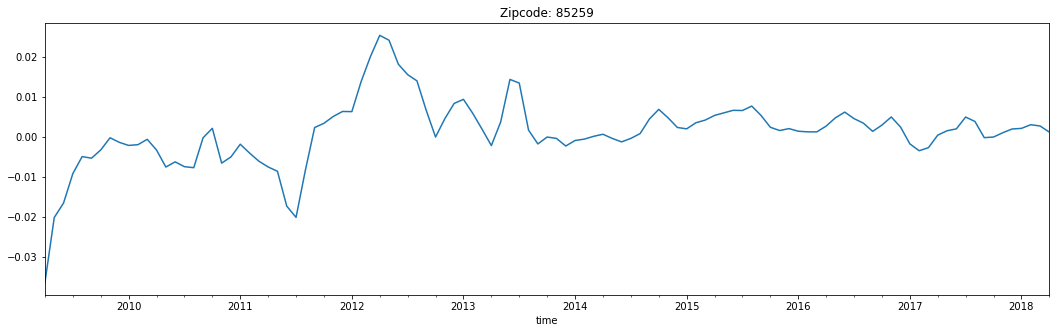

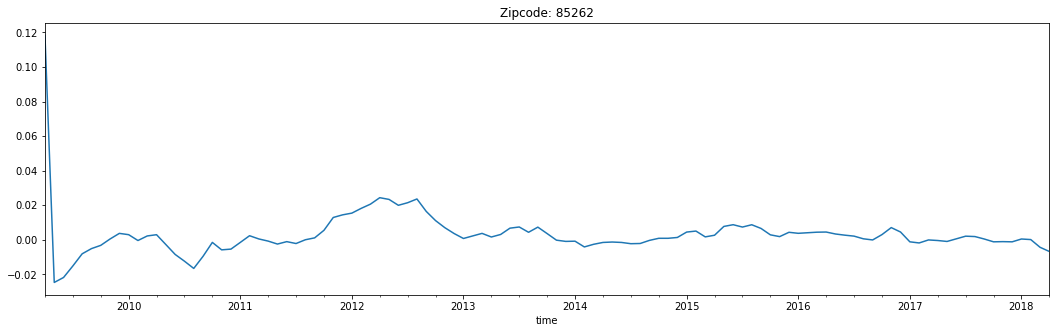

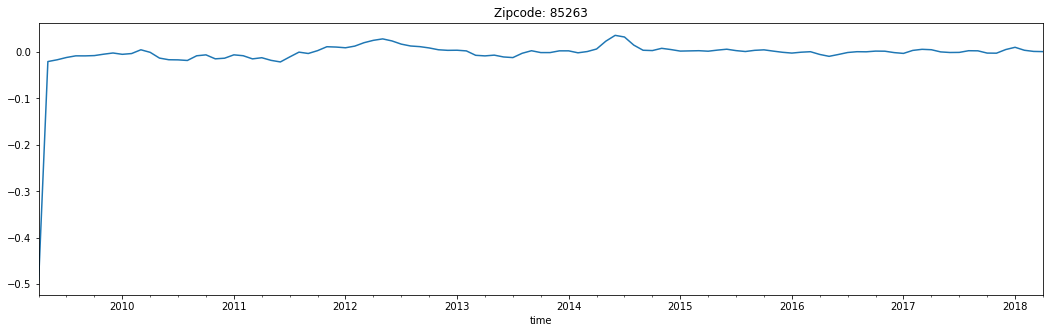

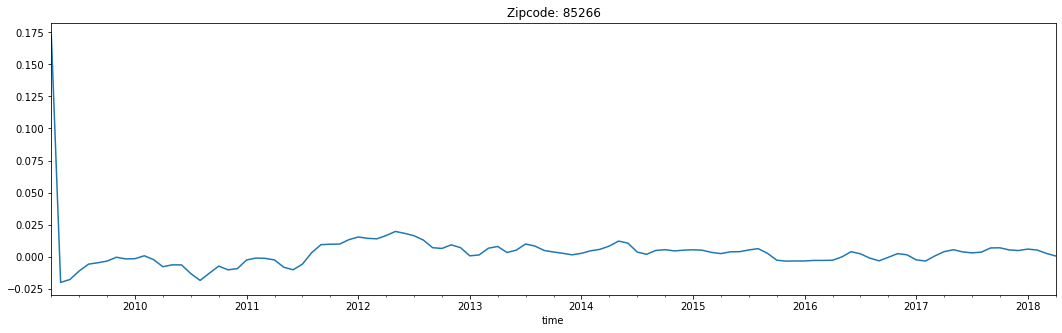

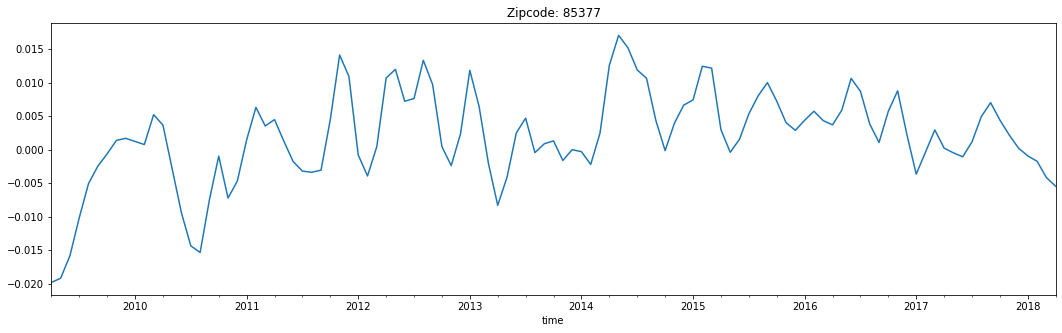

In [20]:
for z in copy.zipcode.unique():
    plot_zip(z,'growth')

In [21]:
growth_not_stationary = []
for z in copy.zipcode.unique():
    print("Monthly Growth For Zipcode: "+ str(z))
    stationarity_check(resampled.loc[z,'growth'])
    print()

Monthly Growth For Zipcode: 85018
Results of Dickey-Fuller Test: 

Test Statistic                 -2.846077
p-value                         0.051987
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64

Monthly Growth For Zipcode: 85054
Results of Dickey-Fuller Test: 

Test Statistic                 -2.763005
p-value                         0.063756
#Lags Used                     11.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64

Monthly Growth For Zipcode: 85253
Results of Dickey-Fuller Test: 

Test Statistic                  -2.106619
p-value                          0.241861
#Lags Used                       7.000000
Number of Observations Used    101.000000
Critical Value (1%)      

Not Stationary Either

### Making Stationary Time Series:

### Growth

In [23]:
# zipcodes to check for
zipcodes = list(resampled.reset_index().zipcode.unique())
zipcodes

[85018, 85054, 85253, 85255, 85258, 85259, 85262, 85263, 85266, 85377]

The stationarity check for zipcode:85018, before differencing

Results of Dickey-Fuller Test: 

Test Statistic                 -2.846077
p-value                         0.051987
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
None

The stationarity check for zipcode:85018, after differencing:

Results of Dickey-Fuller Test: 

Test Statistic                 -4.784243
p-value                         0.000058
#Lags Used                      6.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64
None
None
The stationarity check for zipcode:85054, before differencing

Results of Dickey-Fuller Test: 

Test Statistic                 -2.763005
p-value                         0.063756
#Lags Used

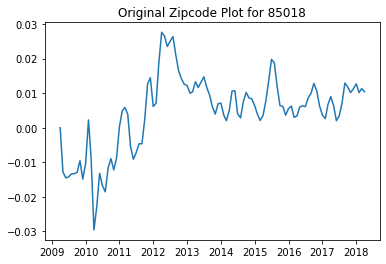

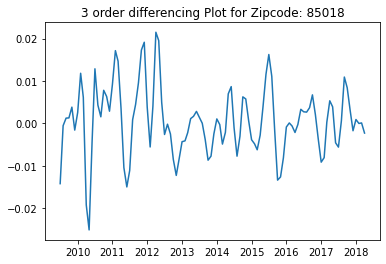

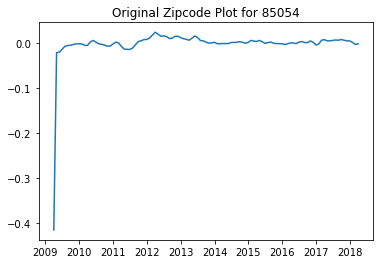

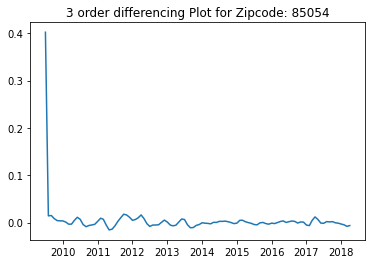

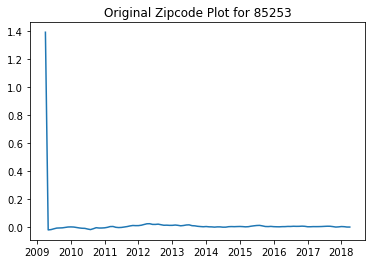

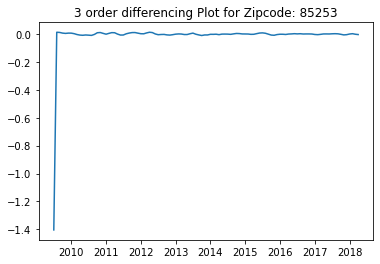

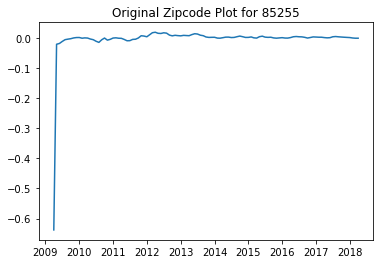

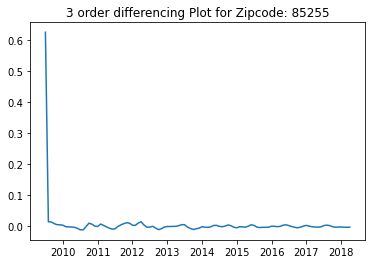

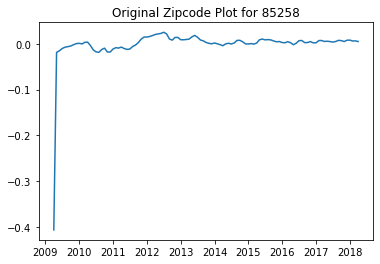

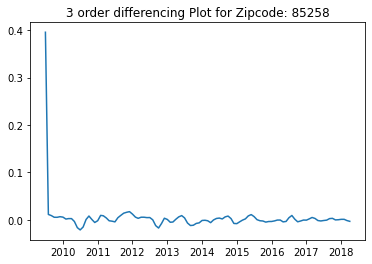

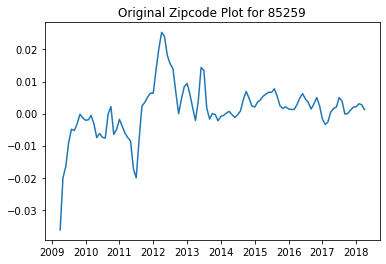

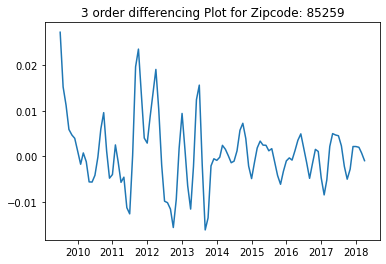

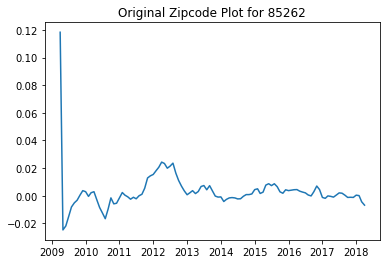

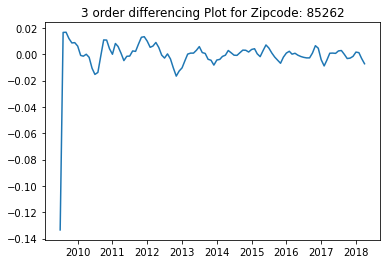

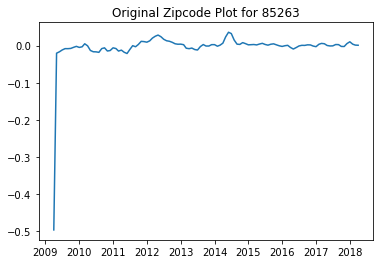

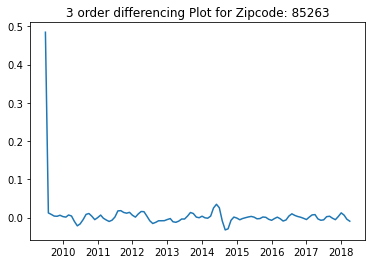

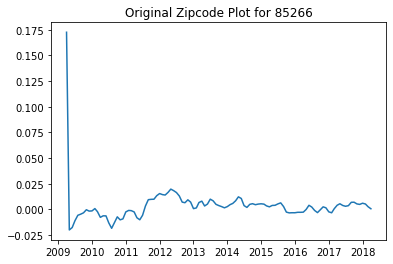

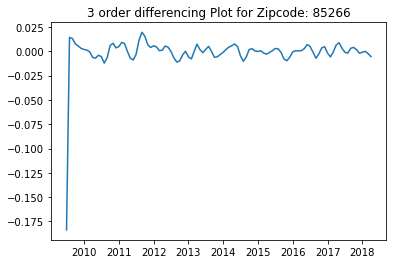

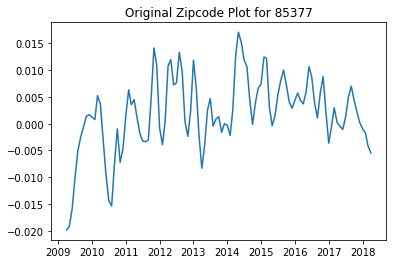

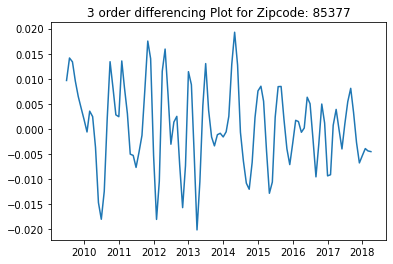

In [25]:
for z in zipcodes:
    print(difference_check(z,'growth',3))    

In [26]:
def p_val_after_diff(zipcode,target,k):
    ts = resampled.loc[zipcode,target]
    ts_diff = ts.diff(k)
    ts_diff.dropna(inplace=True)
    return (zipcode, p_values(ts_diff))

In [27]:
not_stationary = []
for z in zipcodes:
    x = p_val_after_diff(z,'growth',3)
    if x[1] > 0.05:
        not_stationary.append(x)
not_stationary

[(85253, 0.39791423647714164),
 (85259, 0.10903296467569851),
 (85262, 0.19016663535268874),
 (85266, 0.14207022423032512)]

growth still not stationary for zips: 85253, 85259,85262, 85266

In [58]:
bad_zips = [i[0] for i in not_stationary]

[85253, 85259, 85262, 85266]

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(resampled.loc[,['growth']])

In [93]:
def decompose(z,target,plot=False,check=False):
    decomposition = seasonal_decompose(resampled.loc[z,[target]])
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    if plot == True:
        plt.figure(figsize=(12,8))
        plt.subplot(411)
        plt.plot(ts, label='Original', color='blue')
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color='blue')
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color='blue')
        plt.legend(loc='best')
        plt.tight_layout()
        
    ts_decompose = residual
    ts_decompose.dropna(inplace=True)
    
    if check == True:
        stationarity_check(ts_decompose)
        print()
    
    return ts_decompose
        

Results of Dickey-Fuller Test: 

Test Statistic                 -4.443500
p-value                         0.000248
#Lags Used                     11.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64



time
2009-10-01   -0.051146
2009-11-01    0.002991
2009-12-01    0.005277
2010-01-01    0.005903
2010-02-01    0.005178
                ...   
2017-06-01   -0.000236
2017-07-01    0.001206
2017-08-01    0.002320
2017-09-01    0.001857
2017-10-01    0.006183
Name: resid, Length: 97, dtype: float64

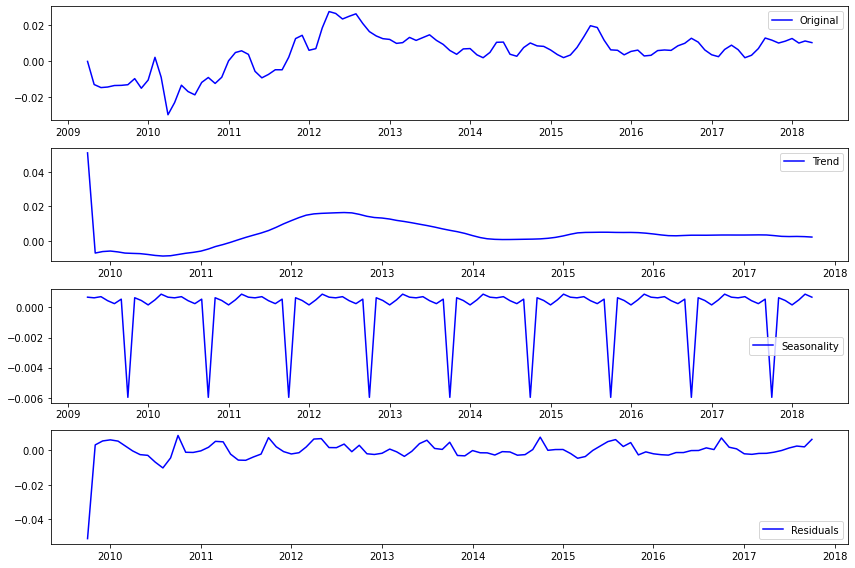

In [94]:
decompose(85253,'growth',True,True)

In [95]:
for z in zipcodes:
    print(f"For Zipcode: {z}")
    print(decompose(z,'growth',check=True))

For Zipcode: 85018
Results of Dickey-Fuller Test: 

Test Statistic                -5.734177e+00
p-value                        6.495835e-07
#Lags Used                     1.000000e+01
Number of Observations Used    8.600000e+01
Critical Value (1%)           -3.508783e+00
Critical Value (5%)           -2.895784e+00
Critical Value (10%)          -2.585038e+00
dtype: float64

time
2009-10-01   -0.001846
2009-11-01    0.003387
2009-12-01   -0.000669
2010-01-01    0.003794
2010-02-01    0.015727
                ...   
2017-06-01   -0.005216
2017-07-01   -0.004422
2017-08-01   -0.001634
2017-09-01    0.003313
2017-10-01    0.002355
Name: resid, Length: 97, dtype: float64
For Zipcode: 85054
Results of Dickey-Fuller Test: 

Test Statistic                 -3.881038
p-value                         0.002179
#Lags Used                     11.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)        

decomposition fixed all except 85266

In [96]:
new_df = pd.DataFrame() 

In [98]:
for z in zipcodes:
    new_df[str(z)] = decompose(z,'growth')

In [99]:
new_df

,85018,85054,85253,85255,85258,85259,85262,85263,85266,85377
time,,,,,,,,,,
2009-10-01,-0.001846,0.018027,-0.051146,0.026756,0.015602,0.003683,-0.002068,0.018000,-0.003838,0.003455
2009-11-01,0.003387,0.003884,0.002991,0.004954,0.002597,0.004909,0.004732,0.001868,0.005354,0.003971
2009-12-01,-0.000669,0.003177,0.005277,0.004878,0.004603,0.003134,0.006560,0.004632,0.003293,0.003386
2010-01-01,0.003794,0.002111,0.005903,0.004415,0.005305,0.002094,0.005566,0.002582,0.003257,0.003025
2010-02-01,0.015727,0.000032,0.005178,0.002061,0.004232,0.002193,0.002356,0.004163,0.005700,0.002822
...,...,...,...,...,...,...,...,...,...,...
2017-06-01,-0.005216,0.000148,-0.000236,-0.001962,-0.000926,0.000831,0.000479,-0.001913,-0.000177,-0.002481
2017-07-01,-0.004422,0.001189,0.001206,0.001964,-0.001977,0.004357,0.002630,-0.002426,-0.000416,0.000076
2017-08-01,-0.001634,0.002097,0.002320,0.003507,-0.000755,0.003078,0.002650,0.000702,0.000126,0.003797


In [100]:
new_df.describe()

,85018,85054,85253,85255,85258,85259,85262,85263,85266,85377
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.000005,0.000319,-0.000358,0.000418,0.000273,0.000114,0.000161,0.000243,0.000057,0.000207
std,0.005085,0.004067,0.006280,0.004200,0.004300,0.004187,0.003426,0.006298,0.003445,0.004987
min,-0.015151,-0.010649,-0.051146,-0.009200,-0.008362,-0.015510,-0.010997,-0.014443,-0.011263,-0.010819
25%,-0.003047,-0.001980,-0.002237,-0.001931,-0.002416,-0.001834,-0.002068,-0.003068,-0.002200,-0.003828
50%,-0.000362,0.000444,-0.000460,0.000289,-0.000204,0.000019,-0.000297,-0.000157,0.000156,0.000227
75%,0.003123,0.002111,0.002067,0.002322,0.003350,0.002364,0.002592,0.002607,0.002634,0.003820
max,0.015727,0.018027,0.008442,0.026756,0.015602,0.011828,0.009168,0.024882,0.005769,0.011516


In [102]:
stationary = new_df.drop('85266',axis=1)

In [108]:
ts[last_date_of_ts

,85018,85054,85253,85255,85258,85259,85262,85263,85377
time,,,,,,,,,
2017-06-01,-0.005216,0.000148,-0.000236,-0.001962,-0.000926,0.000831,0.000479,-0.001913,-0.002481
2017-07-01,-0.004422,0.001189,0.001206,0.001964,-0.001977,0.004357,0.002630,-0.002426,0.000076
2017-08-01,-0.001634,0.002097,0.002320,0.003507,-0.000755,0.003078,0.002650,0.000702,0.003797
2017-09-01,0.003313,0.001961,0.001857,0.002584,0.001994,-0.001720,0.001115,0.000392,0.006059
2017-10-01,0.002355,0.001661,0.006183,-0.001137,-0.000420,-0.002190,-0.000172,-0.006139,0.003481


# Modeling

In [111]:
def train_test_spt(ts,test_size):
    cutoff = round(ts.shape[0]*(1-test_size))
    train = ts[:cutoff]
    test = ts[cutoff:]
    return (train,test)


In [ ]:
### plot split of series
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(train, label='train')
# ax.plot(test, label='test')
# ax.set_title('Train-Test Split');
# plt.legend();

In [105]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [107]:
#split = TimeSeriesSplit()
#Cross Validation
# Train with ind is train.reset_index()
def cross_val(train_set,p=1,d=1,q=1):
    split = TimeSeriesSplit()
    train_with_ind = train_set.reset_index()
    rmses = []
    for train_ind, val_ind in split.split(train_with_ind):
        ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(p, d, q)).fit()
        preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
        true = train_with_ind.iloc[val_ind, -1]
        rmse.append(np.sqrt(mean_squared_error(true, preds)))
    return np.array(rmses)

### Zipcode: 85018	

In [114]:
train = train_test_spt(stationary['85018'],.2)[0]
test = train_test_spt(stationary['85018'],.2)[1]

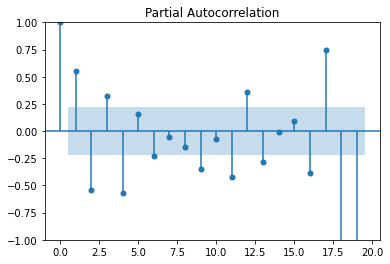

In [121]:
plot_pacf(train);

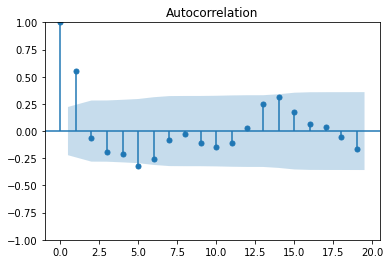

In [122]:
plot_acf(train);

In [123]:
ma_1 = ARIMA(train, order=(2, 0, 1)).fit()

In [124]:
y_hat = ma_1.predict(typ='levels')

In [125]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  85018   No. Observations:                   78
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 329.415
Date:                Wed, 05 Jan 2022   AIC                           -650.829
Time:                        16:17:40   BIC                           -641.402
Sample:                    10-01-2009   HQIC                          -647.056
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.094      0.925      -0.002       0.002
ar.L1          0.3815      0.091      4.172      0.000       0.202       0.561
ma.L1          0.8375      0.077     10.909      0.000       0.687       0.988
sigma2      1.224e-05   1.86e-06      6.592      0.000     8.6e-06    1.59e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.80   Prob(JB):                         0.46
Heteroskedasticity (H):               0.27   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
train_rmse = np.sqrt(mean_squared_error(train, y_hat))
train_rmse

0.0035597814365169217

In [132]:
split = TimeSeriesSplit()
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.014026994758717997
0.016712930434670616
0.005326529489823718
0.0033824768996556583
0.006728649606822982


In [ ]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [28]:
ts = resampled.loc[85018,['growth']]
ts

,growth
time,
2009-04-01,0.000000
2009-05-01,-0.012827
2009-06-01,-0.014522
2009-07-01,-0.014219
2009-08-01,-0.013375
...,...
2017-12-01,0.011223
2018-01-01,0.012707
2018-02-01,0.010165


In [29]:
cutoff = round(ts.shape[0]*0.8)
cutoff

87

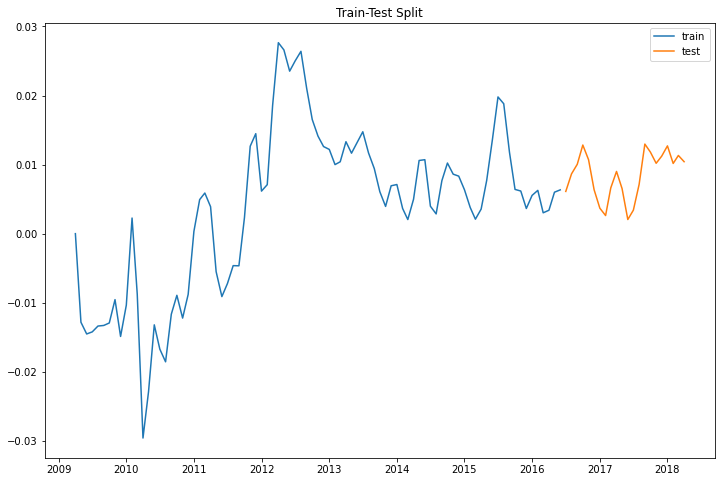

In [30]:
train = ts[:cutoff]

test = ts[cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [31]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] [31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] [45 46 47 48 49 50 51 52 53 54 55 56 57 58]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58] [59 60 61 62 63 64 65 66 67 68 69 70 71 72]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72] [73 74 75 76 77 78 79 80 81 82 83 84 85 86]


In [32]:
baseline = train.shift(1)
baseline

,growth
time,
2009-04-01,NaN
2009-05-01,0.000000
2009-06-01,-0.012827
2009-07-01,-0.014522
2009-08-01,-0.014219
...,...
2016-02-01,0.005539
2016-03-01,0.006268
2016-04-01,0.003020


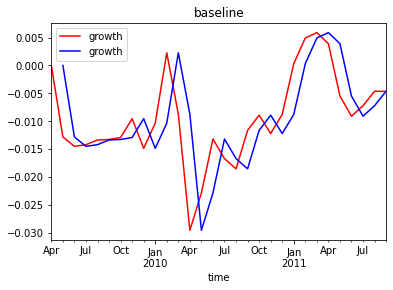

In [33]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [34]:
np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

0.005191819026814273

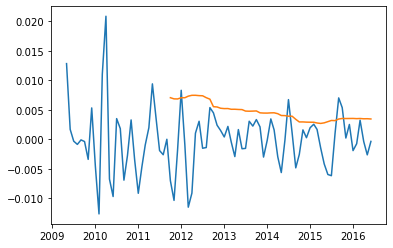

In [35]:
fig, ax = plt.subplots()
residuals = baseline[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

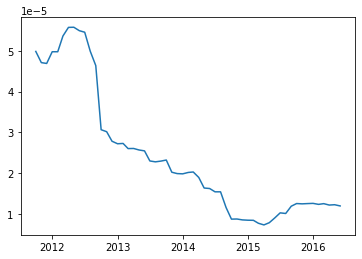

In [36]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

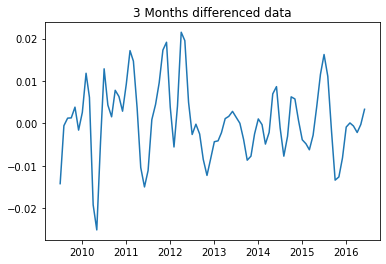

In [37]:
fig, ax = plt.subplots()
ax.plot(train.diff(3).dropna())
ax.set_title('3 Months differenced data');

In [38]:
p_val = adfuller(train.diff(3)[1:].dropna())[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.0009386804360347777,
 so we can safely assume that the differenced data is stationary.


In [39]:
ar_1 = ARIMA(train, order=(0, 3, 1),).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


2009-04-01    0.000000
2009-05-01    0.000000
2009-06-01   -0.032067
2009-07-01   -0.005086
2009-08-01   -0.007352
                ...   
2016-02-01    0.007603
2016-03-01    0.007143
2016-04-01   -0.000148
2016-05-01    0.003891
2016-06-01    0.008786
Freq: MS, Name: predicted_mean, Length: 87, dtype: float64

In [40]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   87
Model:                 ARIMA(0, 3, 1)   Log Likelihood                 302.203
Date:                Wed, 05 Jan 2022   AIC                           -600.405
Time:                        14:28:21   BIC                           -595.543
Sample:                    04-01-2009   HQIC                          -598.451
                         - 06-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9877      0.327     -3.023      0.003      -1.628      -0.347
sigma2      4.203e-05    1.4e-05      2.993      0.003    1.45e-05    6.96e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                76.45
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
train_with_ind = train.reset_index()

In [42]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 3, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.08489179157591284
0.3253627105113007
0.0462910093521914


/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.21329782591143695
0.1577085411853522


/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


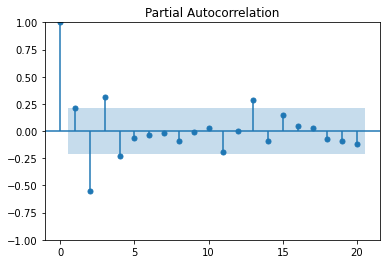

In [43]:
plot_pacf(train.diff().dropna());

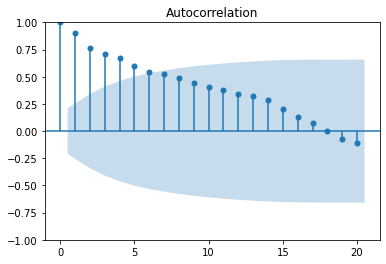

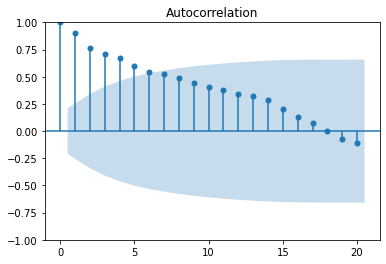

In [44]:
plot_acf(train)

### Trying out Facebook Prophet Forecasting on Zipcode: 85018

In [45]:
import warnings
warnings.simplefilter('ignore')

from fbprophet import Prophet

In [46]:
model = Prophet(interval_width=0.95,weekly_seasonality=True, daily_seasonality=True)

In [47]:
zipcode_85018 = resampled.loc[85253,['growth']]
zipcode_85018.rename(columns={'growth':'y'},inplace=True)
zipcode_85018.index.name = 'ds'
zipcode_85018 = zipcode_85018.reset_index()
zipcode_85018 = zipcode_85018[['ds','y']]
zipcode_85018

,ds,y
0,2009-04-01,1.390880
1,2009-05-01,-0.021071
2,2009-06-01,-0.018717
3,2009-07-01,-0.013178
4,2009-08-01,-0.007995
...,...,...
104,2017-12-01,0.000621
105,2018-01-01,0.002918
106,2018-02-01,0.001919
107,2018-03-01,-0.000494


In [48]:
model.fit(zipcode_85018)

Trying to forecast home value for the next 60 months (or 5 years)

In [49]:
future = model.make_future_dataframe(periods=5*12,freq='MS')

In [50]:
forecast = model.predict(future)

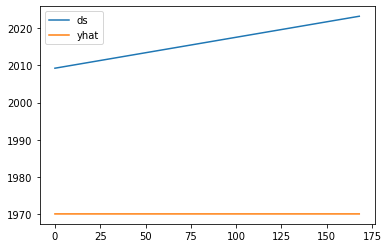

In [51]:
forecast_plot = forecast[['ds','yhat']]
forecast_plot.plot();

(-0.5, 0.5)

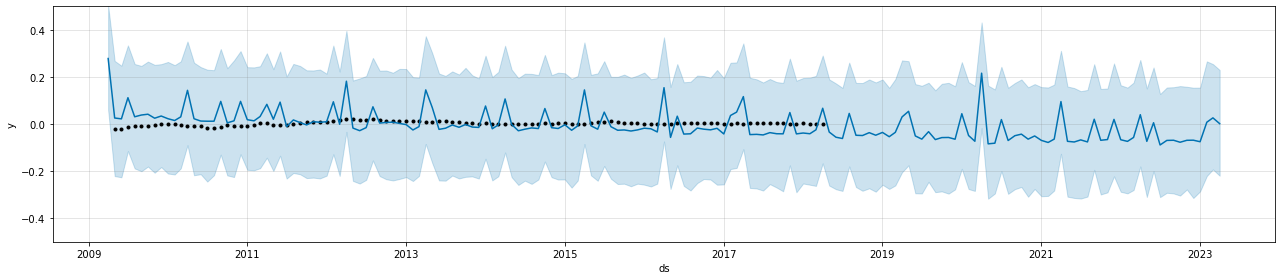

In [52]:
fig, ax = plt.subplots(figsize=(18,4)) 
model.plot(forecast, uncertainty=True,ax = ax)
plt.ylim((-0.5,0.5))

In [53]:
def fb_prophet_model(Zip,target):
    model = Prophet(interval_width=0.95,weekly_seasonality=True, daily_seasonality=True)
    ts = resampled.loc[Zip,[target]].reset_index()
    ts.rename(columns={target:'y','time':'ds'},inplace=True)
    ts = zipcode_85018[['ds','y']]
    return model.fit(ts)

In [54]:
def predict(model,k_periods,plot=False):
    future = model.make_future_dataframe(periods=k_periods,freq='MS')
    forecast = model.predict(future)
    if plot == True:
        fig, ax = plt.subplots(figsize=(18,4)) 
        model.plot(forecast, uncertainty=True,ax = ax)
        plt.ylim((-0.5,0.5))
        return forecast
    return forecast    

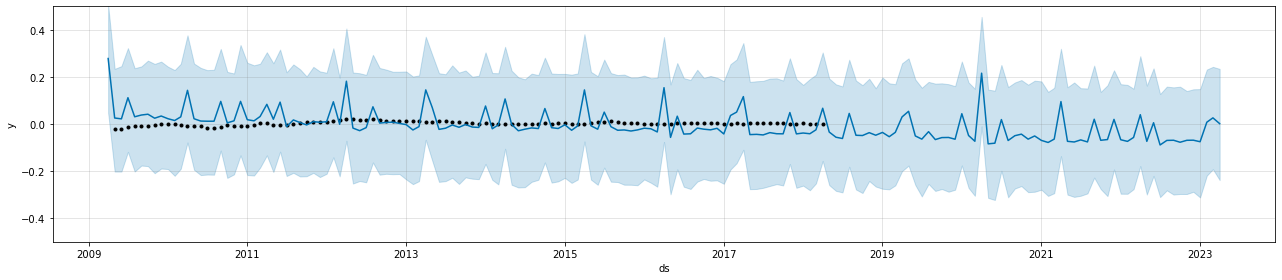

In [55]:
x = fb_prophet_model(85253,'growth')
x_forecast = predict(x,60,True)

In [ ]:
t